<a href="https://colab.research.google.com/github/hppranaav02/bad-poets-society/blob/main/bad_poets_society.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are trying to create a Poetry generator.

* After going through a few styles of poems we have settled on sticking to middle english style of poems for their simple rhyme scheme and broad topics like romance and life

* Right now we are evaluating how miultiple generator systems work.
Templates and grammars, we thought would generate the right rhyme scheme required but due to the varied nature of the themes of the poems selected it would not generate a poem with meaning

* We have decided to use a neural network, specifically a Recurrent Neural Network (RNN). A recurrent neural network fits well for text generation as its structure defines it to use the output of the previoud layer and

**Question 1\:**  What is a LSTM?

**Answer 1\:**

**Step 1**

Load the required libraries from tensorflow, pandas and numpy

* Tensorflow - This is required to import the LSTM neural network model and other tools to help format data
* Pandas - Used to pre-process data which is then supplied to the neural network


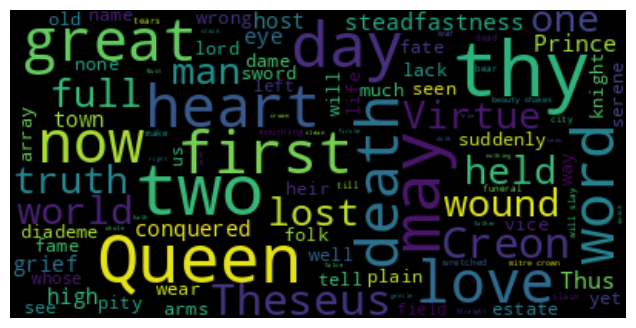

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow.keras.utils as ku
from wordcloud import WordCloud
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers

data = open('sample_data/poems.txt',encoding="utf-8").read();

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()




# New Section